This code runs in R environment

# Figure 4d

In [1]:
suppressPackageStartupMessages({
    library(monocle3)
    library(SeuratWrappers)
    library(mgcv)
    library(ggplot2)
    library(tidyverse)
    library(Seurat)
    library(reticulate)
    library(sceasy)
})

In [43]:
use_condaenv('/Users/jiehoonk/micromamba/envs/sc', '/opt/homebrew/opt/micromamba/bin/micromamba') 
loompy <- reticulate::import('loompy')

data_path <- "/Users/jiehoonk/DevHub/mnt/dataset/jw/output/forNMF/scVI_filter/"
obj <- sceasy::convertFormat(paste0(data_path, 'subcluster.h5ad'), from='anndata', to='seurat')

X -> counts

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from scvi_extra_continuous_covs_ to scviextracontinuouscovs_”


#### Preprocessing in Seurat

In [44]:
Idents(obj) <- obj$cell_type

In [45]:
obj <- SCTransform(obj, verbose = FALSE)

In [46]:
topgenes <- read.csv('/Users/jiehoonk/DevHub/mnt/dataset/jw/markers/nmf_topgenes.csv', row.names = 1)
topgenes <- head(topgenes, 50)

In [47]:
obj <- AddModuleScore(obj, topgenes, name = "NMF_Module_")

#### Convert to cds

In [52]:
cds <- as.cell_data_set(obj)
rowData(cds)$gene_name <- rownames(cds)
rowData(cds)$gene_short_name <- rowData(cds)$gene_name

In [53]:
cds <- estimate_size_factors(cds)
cds <- preprocess_cds(cds)

- copy UMAP coordinated calculated with scVI latent space

In [54]:
partitions <- c(rep(1, length(cds@colData@rownames)))
names(partitions) <- cds@colData@rownames
partitions <- as.factor(partitions)

cds@clusters$UMAP$partitions <- partitions

list_cluster <- obj@active.ident
cds@clusters$UMAP$clusters <- list_cluster

cds@int_colData@listData$reducedDims$UMAP <- obj@reductions$umap@cell.embeddings

In [55]:
cds <- cluster_cells(cds, reduction_method = "UMAP")

#### Learn graph

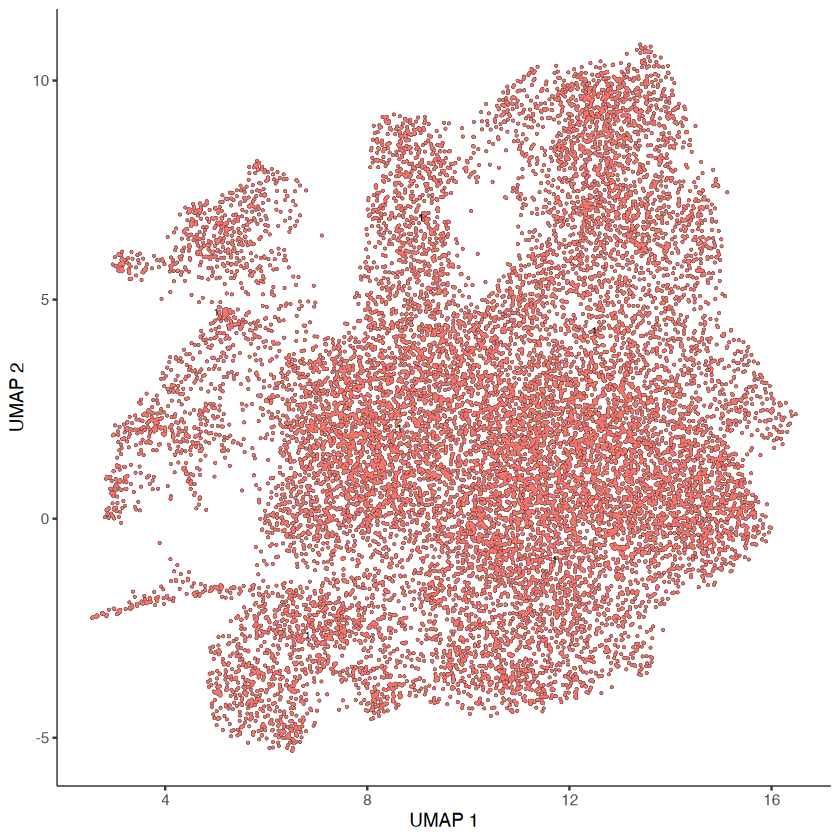

In [9]:
plot_cells(cds, show_trajectory_graph = F, color_cells_by = "partition")

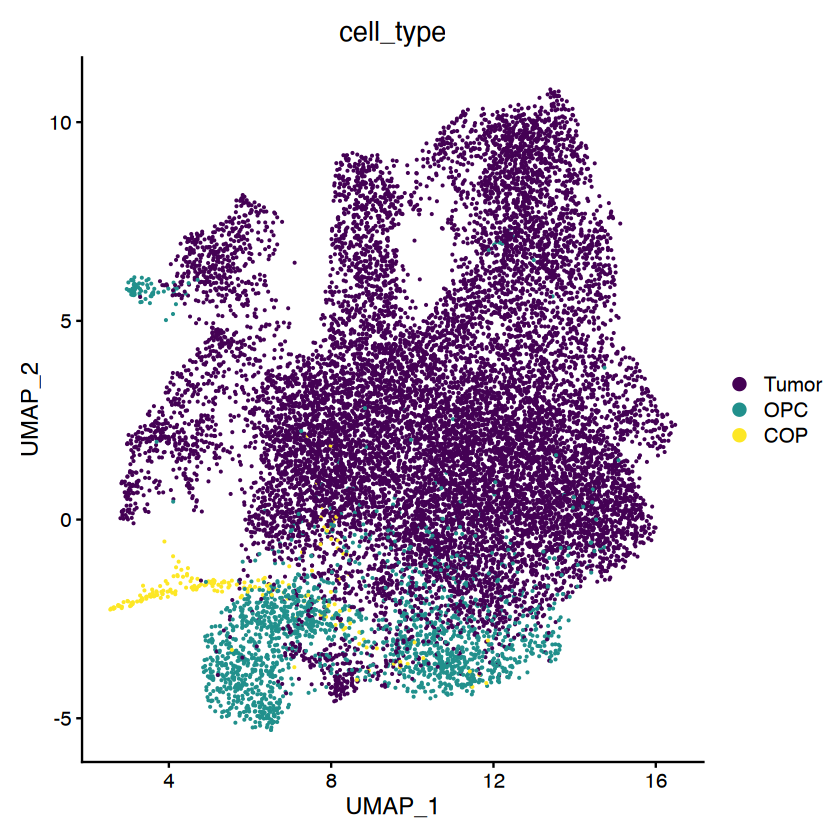

In [16]:
DimPlot(obj, group.by = "cell_type")

In [56]:
cds <- learn_graph(cds, use_partition = FALSE, close_loop = FALSE, learn_graph_control = list(minimal_branch_len = 5))

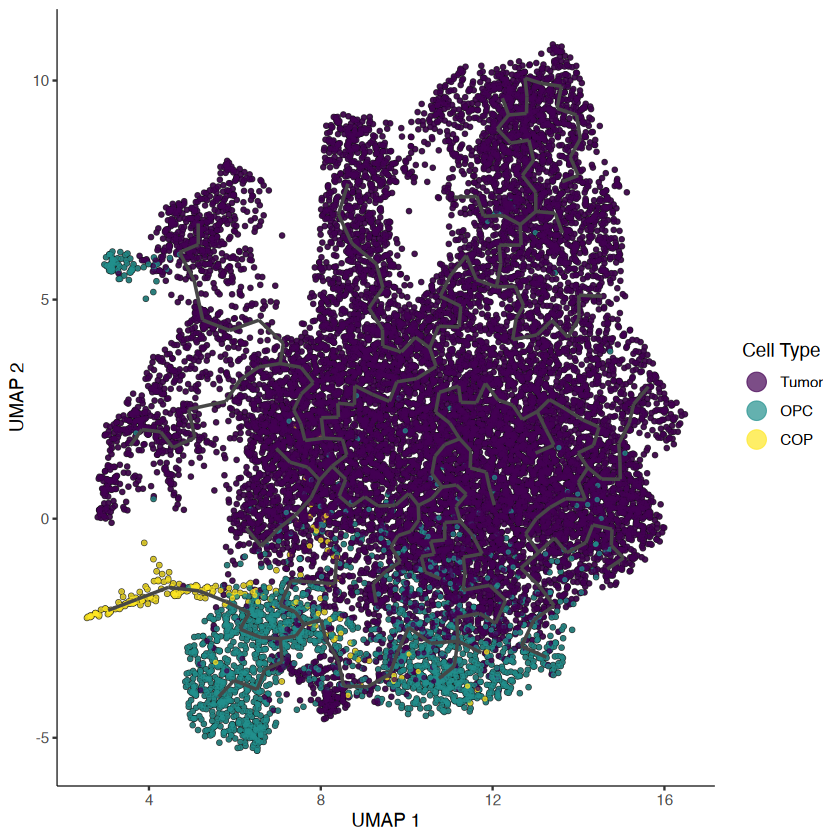

In [10]:
p1 <- plot_cells(cds, color_cells_by = "cell_type", 
           label_groups_by_cluster = F, 
           label_cell_groups = F,
           label_branch_points = F, 
           label_roots = F, 
           label_leaves = F, 
           alpha = 0.7,
           cell_size = 0.7,
           group_label_size = 5)
p1 <- p1 + 
  theme(legend.position = "right") +
  guides(color = guide_legend(title = "Cell Type", override.aes = list(size = 5)))
p1

#### Select root cells

In [4]:
get_earliest_principal_node <- function(cds){
  cell_ids <- which(colData(cds)[, "cell_type"] == "OPC")
  
  closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <- igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names(which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}
cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))

Cells aren't colored in a way that allows them to be grouped.



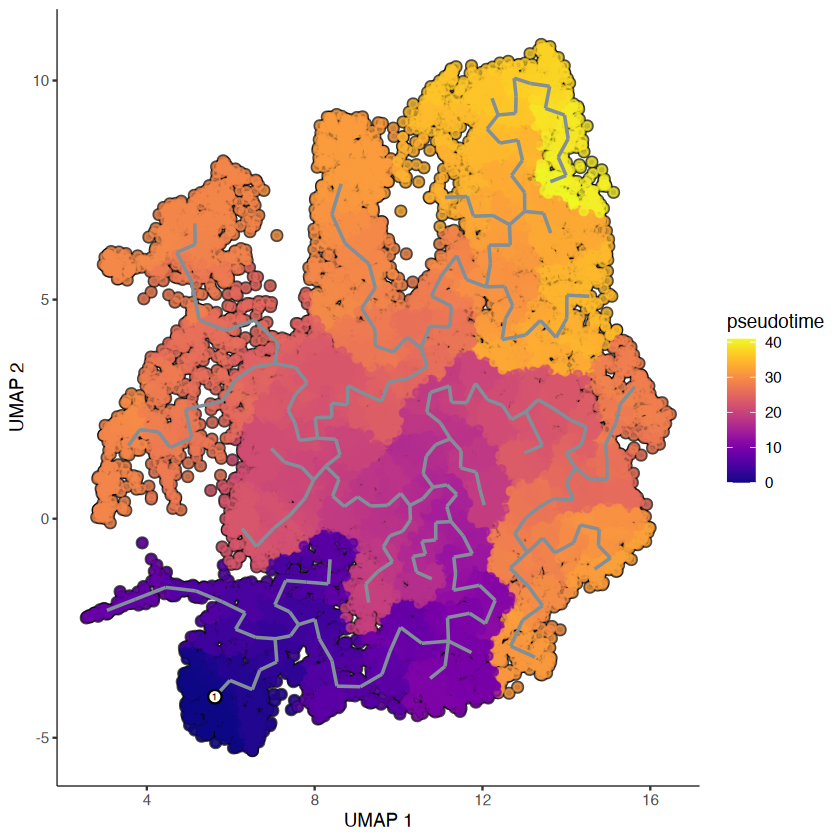

In [74]:
p2 <- plot_cells(cds, color_cells_by = "pseudotime", 
           label_groups_by_cluster = F, 
           label_branch_points = F, 
           label_roots = T, 
           label_leaves = F, 
           group_label_size = 5,
           alpha = 0.7, 
           cell_size= 1.5,
           trajectory_graph_color = '#808F98') 
p2
#  ggsave('Fig4G_trajectory_graph_green_grey4.pdf', p2, device = 'pdf', dpi = 300)

In [ ]:
pt <- pseudotime(cds,reduction_method = "UMAP")
cds$Pseudotime <- pt

In [83]:
write.csv(cds$Pseudotime, '/Users/jiehoonk/DevHub/mnt/dataset/jw/markers/pseudotime.csv')